# <center> Capstone проект №3 <br> Прогнозирование временных рядов на карте

## <center> Неделя 4 <br> Прогнозирование большого количества рядов

Процесс подбора модели ARIMA в Питоне достаточно трудоёмок, поэтому мы не сможем вручную подобрать модель для каждого из рядов в выбранных ячейках. Чтобы облегчить ручной перебор, необходимо кластеризовать временные ряды и подобрать гиперпараметры модели ARIMA только один раз для всех рядов каждого кластера. 

In [1]:
import pandas as pd
import statsmodels.api as sm
from sklearn import linear_model
from scipy import stats
%pylab inline
from glob import glob
import os
import itertools
from tqdm import tqdm_notebook
from sklearn.preprocessing import StandardScaler
from sklearn.manifold import TSNE
import matplotlib.cm as cm # импортируем цветовые схемы, чтобы рисовать графики.
from statsmodels.tsa.stattools import acf, pacf
from scipy.cluster import hierarchy
#from scipy.spatial.distance import pdist
from sklearn.cluster import KMeans
from pandas.tseries.holiday import USFederalHolidayCalendar as calendar

Populating the interactive namespace from numpy and matplotlib


### Загрузка данных

Для начала загрузим все имеющиеся данные:

In [2]:
def load_train_data(path_to_files,n_files=0):
    data_load = []
    path_files_list = glob(os.path.join(path_to_files, 'prepare_data*.csv'))
    path_files_list.sort()
    for path_file in tqdm_notebook(path_files_list[-n_files:]):
        data_load.append(pd.read_csv(path_file, parse_dates=['time'], dtype={'region':int,'count':int}))
    return pd.concat(data_load)

In [3]:
data = load_train_data('/data/Prepare_data')

Создадим список ячеек, отобранных на 2 неделе:

In [4]:
data_may = pd.read_csv('/data/Prepare_data/prepare_data_2016-05.csv', index_col=['time'],parse_dates=['time'], dtype={'region':int,'count':int})
n_hours = len(data_may[data_may['region'] == 1].index)
count_month = data_may.groupby('region').sum()
counts_per_hour = count_month / n_hours
counts_per_hour_filt = counts_per_hour[counts_per_hour['count'] >= 5]
list_region = list(counts_per_hour_filt.index)
print(f'Количество отобранных ячеек: {len(list_region)}')

Количество отобранных ячеек: 102


Составим из отобранных данных о поездках прямоугольную таблицу так, чтобы по строкам было время, а по столбцам идентификатор ячейки:

In [5]:
data = data[data.region.apply(lambda x: x in list_region)]

In [6]:
all_data = pd.DataFrame(data.pivot_table('count',index='time',columns='region'))

Далее не будем использовать данные за последние имеющиеся месяцы — май и июнь 2016:

In [7]:
train_data = all_data[:'2016-04']

In [8]:
train_data.tail()

region,1075,1076,1077,1125,1126,1127,1128,1129,1130,1131,...,1630,1684,1733,1734,1783,2068,2069,2118,2119,2168
time,,,,,,,,,,,,,,,,,,,,,
2016-04-30 19:00:00,121,209,145,101,345,445,519,724,817,244,...,1,0,5,152,83,140,5,158,59,84
2016-04-30 20:00:00,107,208,99,107,290,411,543,733,840,210,...,2,0,2,141,41,119,11,232,50,120
2016-04-30 21:00:00,91,155,108,115,318,463,600,875,831,152,...,2,0,2,190,67,129,16,158,81,117
2016-04-30 22:00:00,100,97,85,100,217,421,697,955,909,203,...,1,0,2,230,80,132,21,198,23,93
2016-04-30 23:00:00,92,118,63,86,284,529,733,838,918,185,...,4,0,0,195,54,134,10,181,74,39


In [9]:
print(f'В итоге имеем данные с {min(train_data.index)} по {max(train_data.index)}')

В итоге имеем данные с 2011-01-01 00:00:00 по 2016-04-30 23:00:00


### Cтандартизация рядов

Для стандартизации рядов будем использовать функцию из sklearn:

In [10]:
train_data_norm = StandardScaler().fit_transform(train_data)

### Кластеризация географических зон

На данном этапе нам необходимо подобрать число кластеров так, чтобы оно было не слишком большим, но ряды внутри кластеров имели похожую форму.

В лоб вычислять похожесть рядов мы не можем, ввиду большой размерности.

Мы имеет временные ряды с четко выраженной сезонностью (годовой, недельной, суточной), которая прекрасно описывается рядами Фурье. Представим каждый ряд фиксированным набором частот и вычислим с помощью линейной регрессии коэффициенты при каждой частоте. Эти коэффициенты и будут являться признаками для моделем кластеризации.

In [11]:
def generate_features(time_series,k_day, k_week, k_year, k_pol):
    train_exog = generate_lin_exog(time_series, k_day, k_week, k_year, k_pol)
    lin_model = linear_model.LinearRegression().fit(train_exog,time_series)
    #exog_acf = acf(time_series)[:12]
    #features = np.hstack((lin_model.coef_, exog_acf))
    features = lin_model.coef_
    return features

In [12]:
def generate_lin_exog(time,k_day,k_week,k_year,k_pol):
    T = len(time)
    T_arr = np.arange(1, T + 1)
    exog_sin_day = np.zeros((T,k_day))
    exog_cos_day = np.zeros((T,k_day))
    exog_sin_week = np.zeros((T,k_week))
    exog_cos_week = np.zeros((T,k_week))
    exog_sin_year = np.zeros((T,k_year))
    exog_cos_year = np.zeros((T,k_year))
    exog_polinom = np.zeros((T,k_pol))
    
    for i in range(k_day):
        exog_sin_day[:,i] = np.sin(T_arr * 2 * pi * (i+1) / 24)
        exog_cos_day[:,i] = np.cos(T_arr * 2 * pi * (i+1) / 24)
    
    for i in range(k_week):
        exog_sin_week[:,i] = np.sin(T_arr * 2 * pi * (i+1) / 168)
        exog_cos_week[:,i] = np.cos(T_arr * 2 * pi * (i+1) / 168)
        
    for i in range(k_year):
        exog_sin_year[:,i] = np.sin(T_arr * 2 * pi * (i+1) / 8760)
        exog_cos_year[:,i] = np.cos(T_arr * 2 * pi * (i+1) / 8760)
        
    for i in range(k_pol):
        exog_polinom[:,i] = T_arr**(i+1)
        
    exog = np.concatenate((exog_sin_day, exog_cos_day,
                           exog_sin_week, exog_cos_week,
                           exog_sin_year, exog_cos_year, 
                           exog_polinom),axis=1)
    return exog

Возьмем по 6 пар cos и sin для учета недельной сезонности и дневной; 4 пары для годовой и полином 3 степени для учета треда.

In [23]:
features = [generate_features(train_data_norm[:,i],k_day=6,k_week=6,k_year=4,k_pol=3) for i in range(102)]
features = np.array(features)

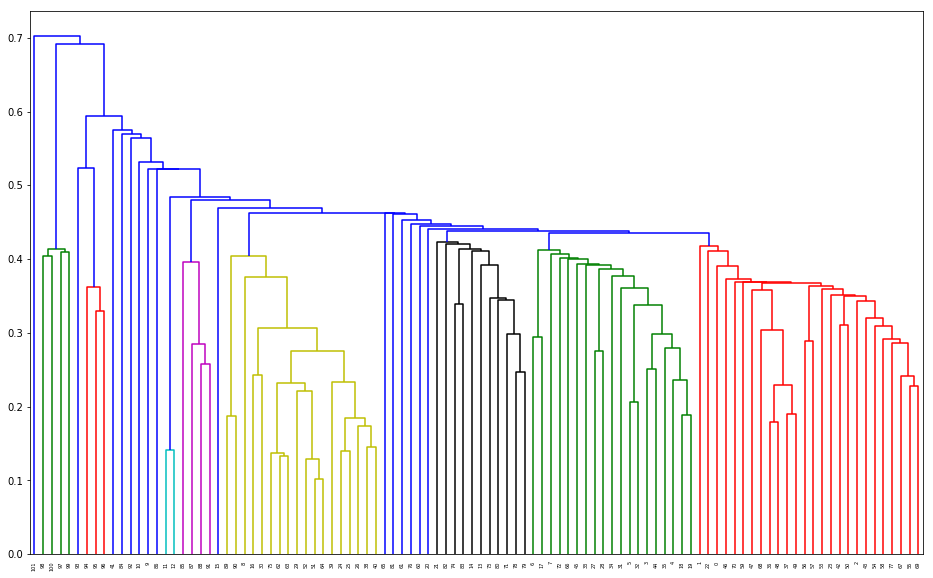

In [146]:
Z = hierarchy.linkage(features)
plt.figure()
dn = hierarchy.dendrogram(Z,color_threshold=0.43)

Визуализируем полученные признаки с помощью T-SNE и кластеризуем с помощью K-means на 5 кластером

P.S. На самом деле было много итераций с количеством признаков, кластеров и методами кластеризации, здесь представлена финальная версия)

In [24]:
tsne = TSNE()
tsne_representation = tsne.fit_transform(features)

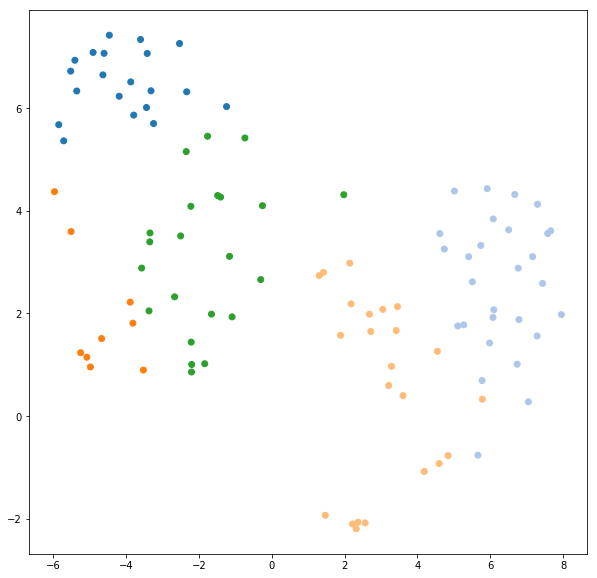

In [25]:
n_clusters = 5
kmeans = KMeans(n_clusters=n_clusters).fit(features)
assignments = kmeans.labels_
colors = cm.tab20(assignments)
plt.figure(figsize=(10,10))
plt.scatter(tsne_representation[:,0],tsne_representation[:,1],c=colors)
plt.show()

Визуализация с помощью T-SNE позволяет оценить примерное количество кластеры, но без random_state она получается всегда разная.

Посмотрим на ряды, сгрупированные по кластерам:

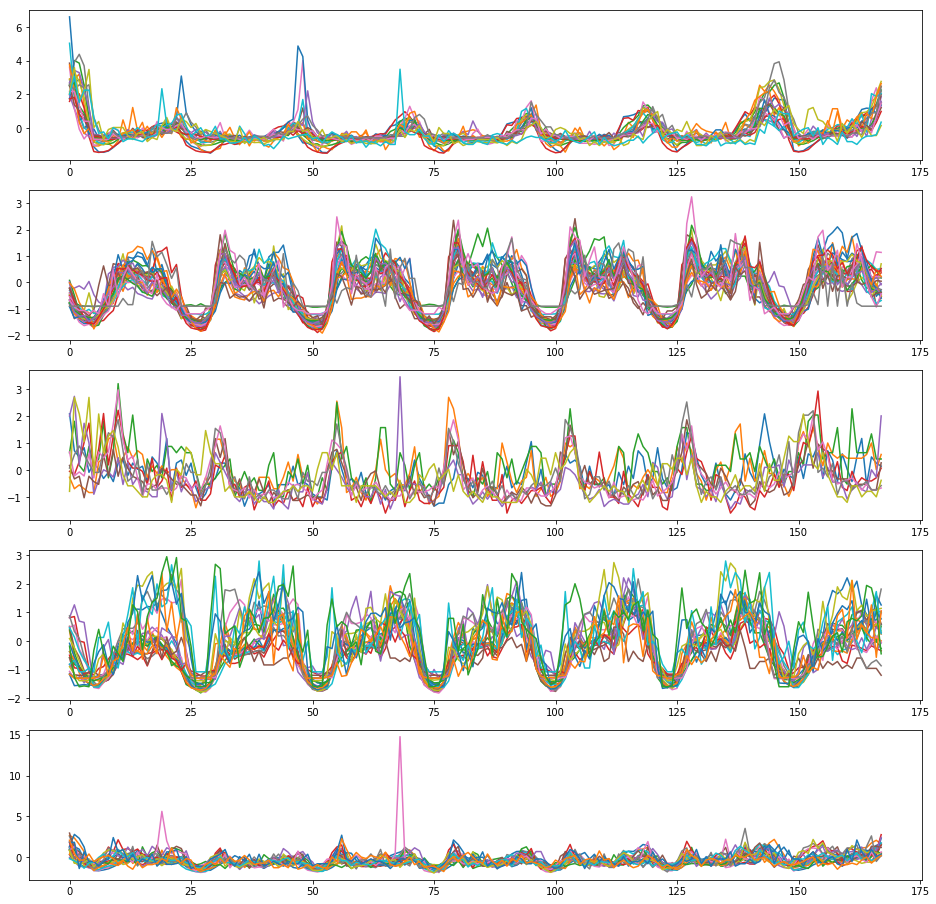

In [26]:
fig, axes = plt.subplots(nrows=n_clusters, ncols=1, figsize=(16, 16))
for i in range(n_clusters):
    axes[i].plot(train_data_norm[:,assignments == i][-168:])

Как видно, в каждом кластере в большинстве случаев присутствуют похожие ряды, а сами кластеры неодинаковые между собой.

### Типовые ряды кластеров

Найдем наиболее ближайшие к центру кластера ряды:

In [27]:
dist_to_claster = [kmeans.transform(features[i:i+1,:])[0,assignments[i]] for i in range(102)]
dist = pd.DataFrame({
    #'region': list_region,
    'claster': assignments,
    'distance': dist_to_claster}, index=list_region)
list_centers = [dist[dist['claster'] == i]['distance'].idxmin() for i in range(n_clusters)]

In [28]:
print(list_centers)

[1378, 1333, 1480, 1233, 1389]


### Выбор параметров ARIMA

Как и на предыдушей неделе создадим признаки на основе рядов Фурье и на них обучим линейную регрессию

In [29]:
def generate_exog(time, k_week, k_year, k_pol):
    T = len(time)
    T_arr = np.arange(1, T + 1)
    exog_sin_week = np.zeros((T,k_week))
    exog_cos_week = np.zeros((T,k_week))
    exog_sin_year = np.zeros((T,k_year))
    exog_cos_year = np.zeros((T,k_year))
    cal = calendar()
    holidays_days = cal.holidays()
    exog_holidays = np.zeros((T,1))
    exog_polinom = np.zeros((T,k_pol))
    
    for i in range(k_week):
        exog_sin_week[:,i] = np.sin(T_arr * 2 * pi * (i+1) / 168)
        exog_cos_week[:,i] = np.cos(T_arr * 2 * pi * (i+1) / 168)
        
    for i in range(k_year):
        exog_sin_year[:,i] = np.sin(T_arr * 2 * pi * (i+1) / 8760)
        exog_cos_year[:,i] = np.cos(T_arr * 2 * pi * (i+1) / 8760)
        
    for i in range(k_pol):
        exog_polinom[:,i] = T_arr**(i+1)
    
    exog_weekday = pd.get_dummies([x.weekday() for x in time]).values
    exog_holidays[:,0] = np.array([int(x in holidays_days) for x in time])
    exog = np.concatenate((exog_sin_week, exog_cos_week,
                           exog_sin_year, exog_cos_year, 
                           exog_weekday, exog_polinom,exog_holidays),axis=1)
    return pd.DataFrame(exog)

In [106]:
# На графиках будем показывать только n_samples отсчетов
n_samples = 8760
param = []

#### Кластер 1

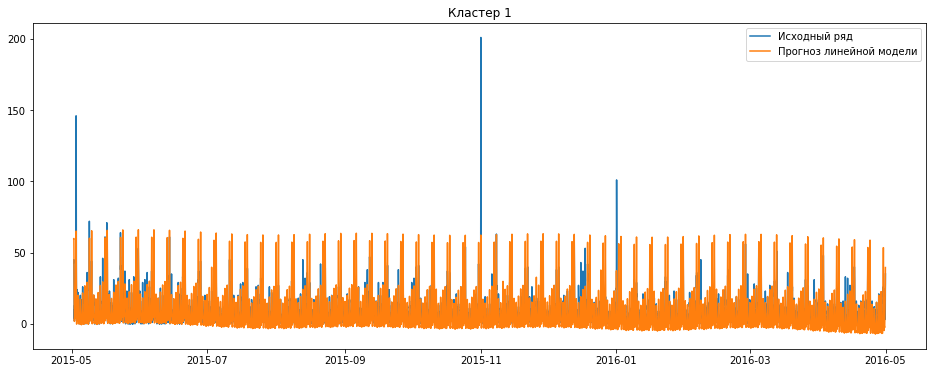

In [108]:
region = list_centers[0]
train_series = train_data.loc[:,region].resample('H').sum()
train_exog = generate_exog(train_data.loc[:,region].index, k_week=28, k_year=4, k_pol=3)
lin_model = linear_model.LinearRegression().fit(train_exog,train_series)
predict = lin_model.predict(train_exog)
plt.figure(figsize=(16,6))
plot(train_series.index[-n_samples:],train_series[-n_samples:],label='Исходный ряд')
plot(train_series.index[-n_samples:],predict[-n_samples:],label='Прогноз линейной модели')
plt.legend()
plt.title(f'Кластер 1')
plt.show()

Посмотрим на остатки

Критерий Дики-Фуллера: p=0.000000


<Figure size 1152x720 with 0 Axes>

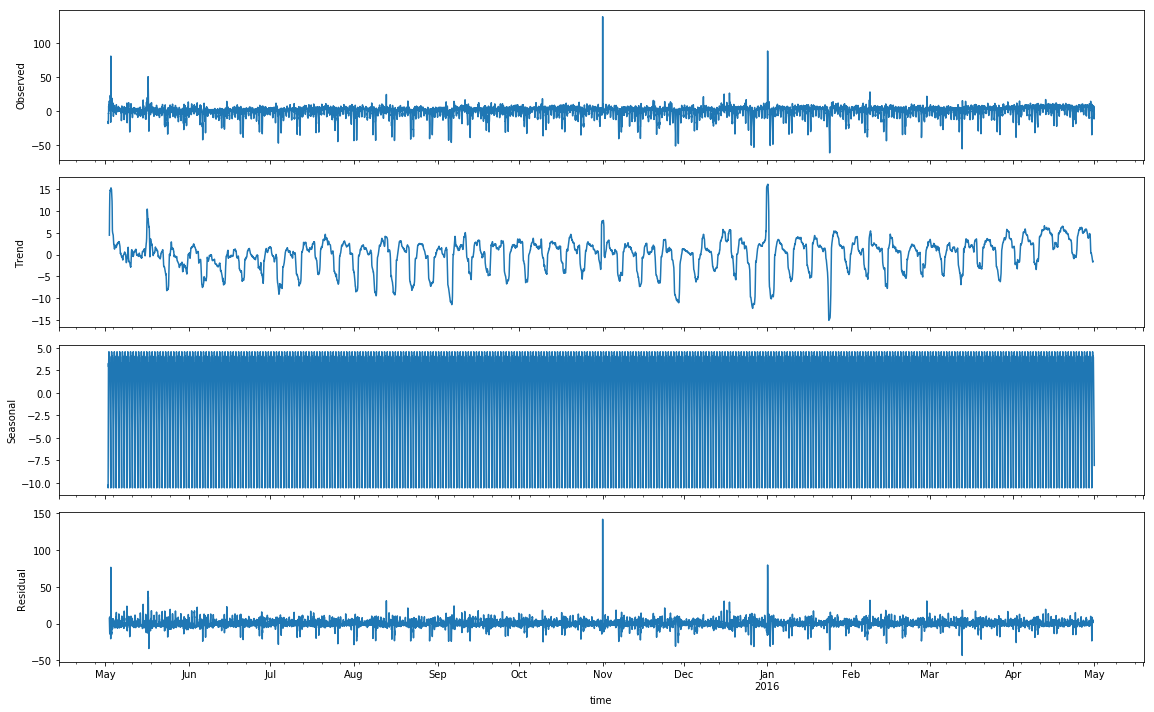

In [109]:
residual = train_series - predict
plt.figure(figsize(16,10))
sm.tsa.seasonal_decompose(residual[-n_samples:]).plot()
print("Критерий Дики-Фуллера: p=%f" % sm.tsa.stattools.adfuller(residual)[1])
plt.show()

Cезонность присутствует, поэтому выполним сезонное дифференцирование:

Критерий Дики-Фуллера: p=0.000000


<Figure size 1152x720 with 0 Axes>

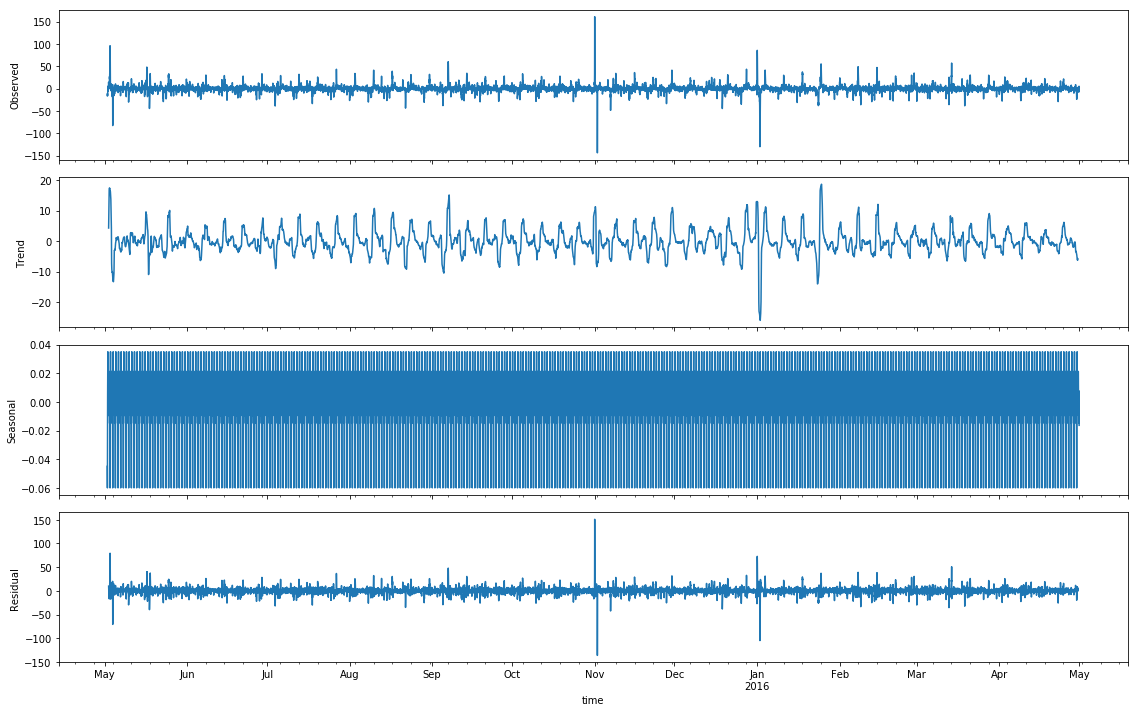

In [110]:
residual_diff = residual - residual.shift(24)
plt.figure(figsize(16,10))
sm.tsa.seasonal_decompose(residual_diff[-n_samples:].dropna()).plot()
print("Критерий Дики-Фуллера: p=%f" % sm.tsa.stattools.adfuller(residual_diff.dropna())[1])
plt.show()

Тренд отсутствует, и выраженная сезонность тоже.

Посмотрим на авторегрессионные функции и определим начальные приближения для ARIMA:

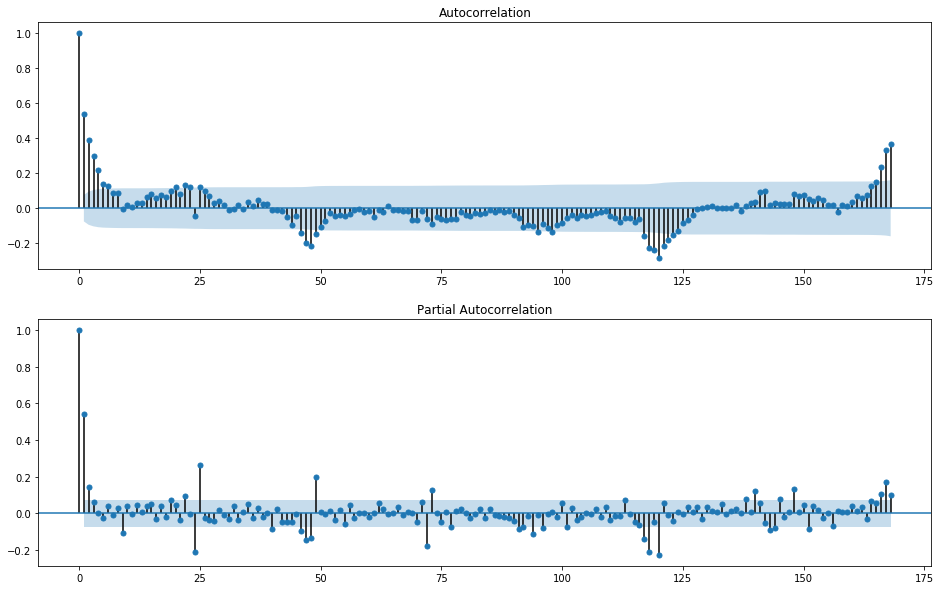

In [111]:
figure(figsize(16,10))
ax = subplot(211)
sm.graphics.tsa.plot_acf(residual_diff[-672:].dropna(), lags=168,ax=ax)
ax = subplot(212)
sm.graphics.tsa.plot_pacf(residual_diff[-672:].dropna(), lags=168,ax=ax)
plt.show()

Начальные приближения: Q=7, q=6, P=5, p=2

In [112]:
param.append((7,6,5,2))

#### Кластер 2

Всё тоже самое проделываем с остальными кластерами:

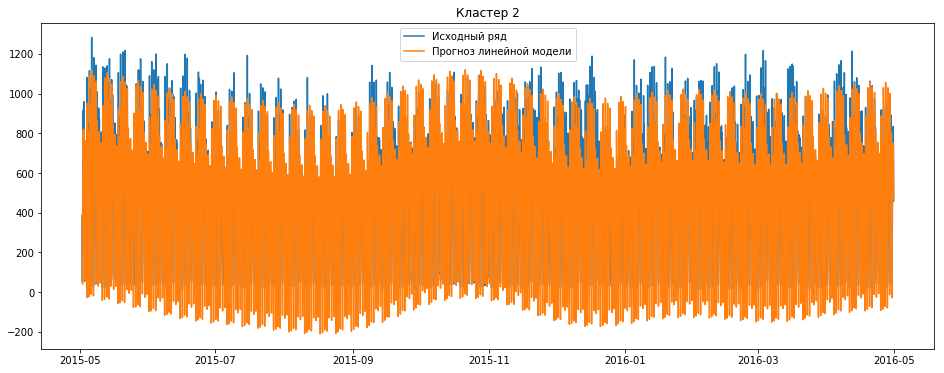

In [113]:
region = list_centers[1]
train_series = train_data.loc[:,region].resample('H').sum()
train_exog = generate_exog(train_data.loc[:,region].index, k_week=28, k_year=4, k_pol=3)
lin_model = linear_model.LinearRegression().fit(train_exog,train_series)
predict = lin_model.predict(train_exog)
plt.figure(figsize=(16,6))
plot(train_series.index[-n_samples:],train_series[-n_samples:],label='Исходный ряд')
plot(train_series.index[-n_samples:],predict[-n_samples:],label='Прогноз линейной модели')
plt.legend()
plt.title(f'Кластер 2')
plt.show()

Критерий Дики-Фуллера: p=0.000000


<Figure size 1152x720 with 0 Axes>

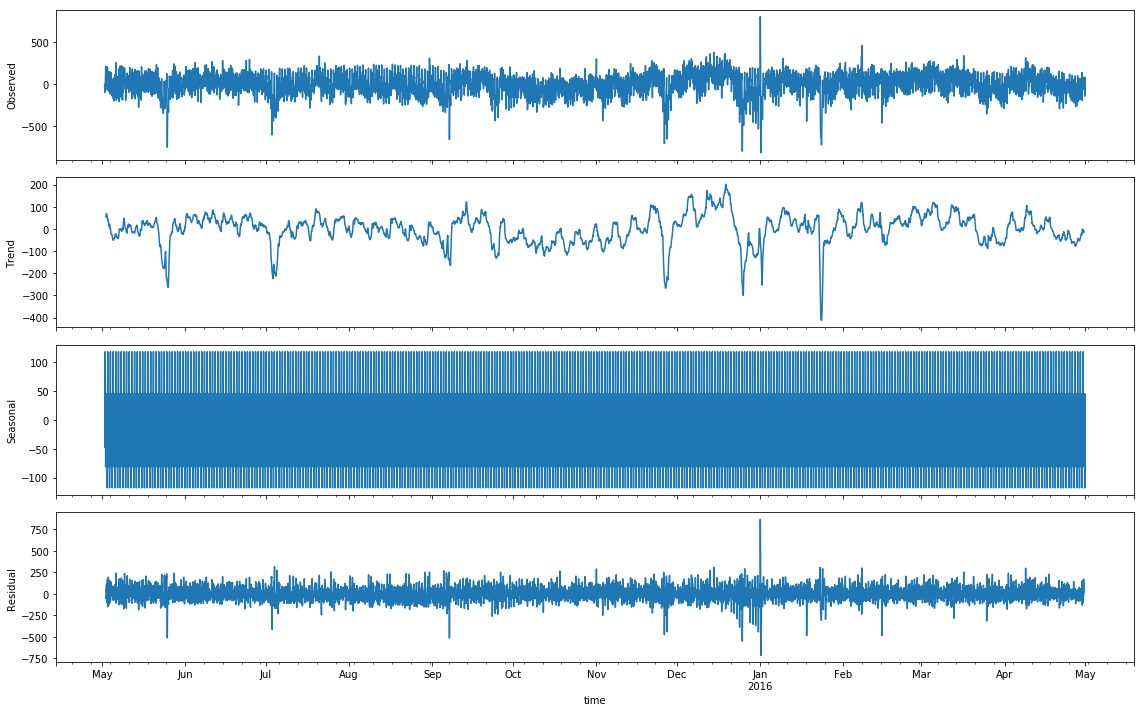

In [114]:
residual = train_series - predict
plt.figure(figsize(16,10))
sm.tsa.seasonal_decompose(residual[-n_samples:]).plot()
print("Критерий Дики-Фуллера: p=%f" % sm.tsa.stattools.adfuller(residual)[1])
plt.show()

Критерий Дики-Фуллера: p=0.000000


<Figure size 1152x720 with 0 Axes>

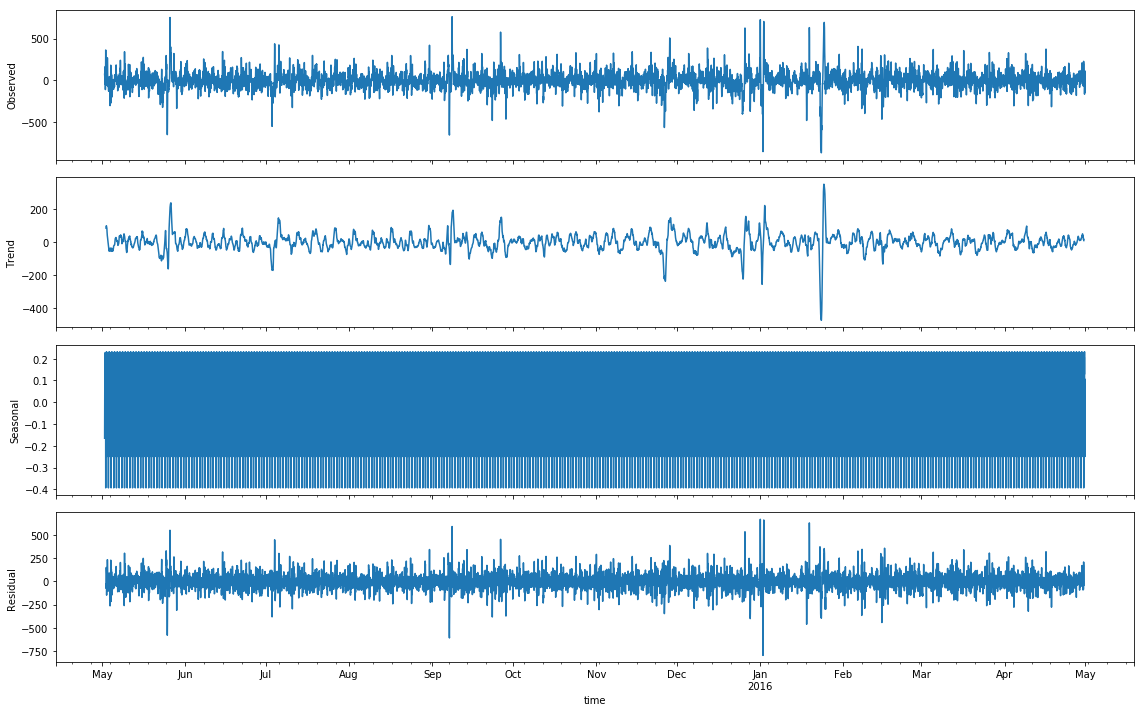

In [115]:
residual_diff = residual - residual.shift(24)
plt.figure(figsize(16,10))
sm.tsa.seasonal_decompose(residual_diff[-n_samples:].dropna()).plot()
print("Критерий Дики-Фуллера: p=%f" % sm.tsa.stattools.adfuller(residual_diff.dropna())[1])
plt.show()

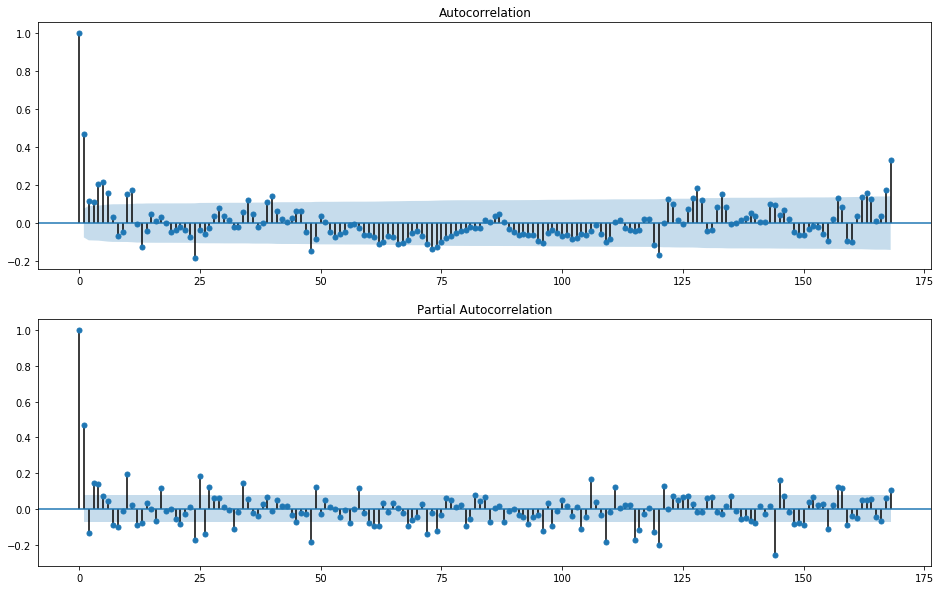

In [116]:
figure(figsize(16,10))
ax = subplot(211)
sm.graphics.tsa.plot_acf(residual_diff[-672:].dropna(), lags=168,ax=ax)
ax = subplot(212)
sm.graphics.tsa.plot_pacf(residual_diff[-672:].dropna(), lags=168,ax=ax)
plt.show()

Начальные приближения: Q=7, q=13, P=6, p=10

In [117]:
param.append((7,13,6,10))

#### Кластер 3

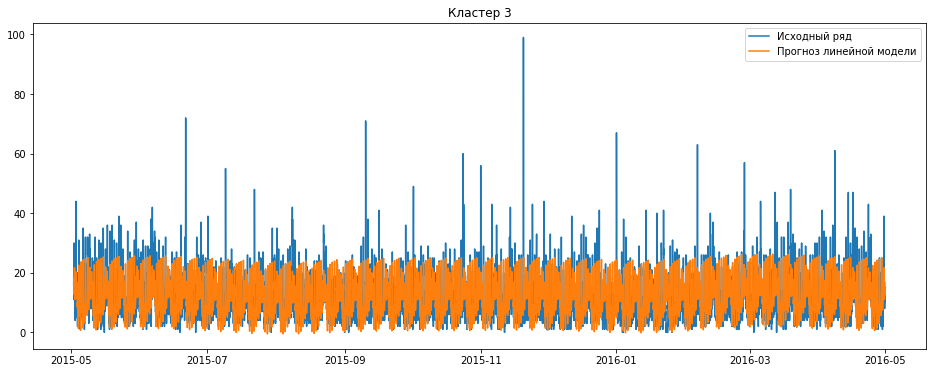

In [118]:
region = list_centers[2]
train_series = train_data.loc[:,region].resample('H').sum()
train_exog = generate_exog(train_data.loc[:,region].index, k_week=28, k_year=4, k_pol=3)
lin_model = linear_model.LinearRegression().fit(train_exog,train_series)
predict = lin_model.predict(train_exog)
plt.figure(figsize=(16,6))
plot(train_series.index[-n_samples:],train_series[-n_samples:],label='Исходный ряд')
plot(train_series.index[-n_samples:],predict[-n_samples:],label='Прогноз линейной модели')
plt.legend()
plt.title(f'Кластер 3')
plt.show()

Критерий Дики-Фуллера: p=0.000000


<Figure size 1152x720 with 0 Axes>

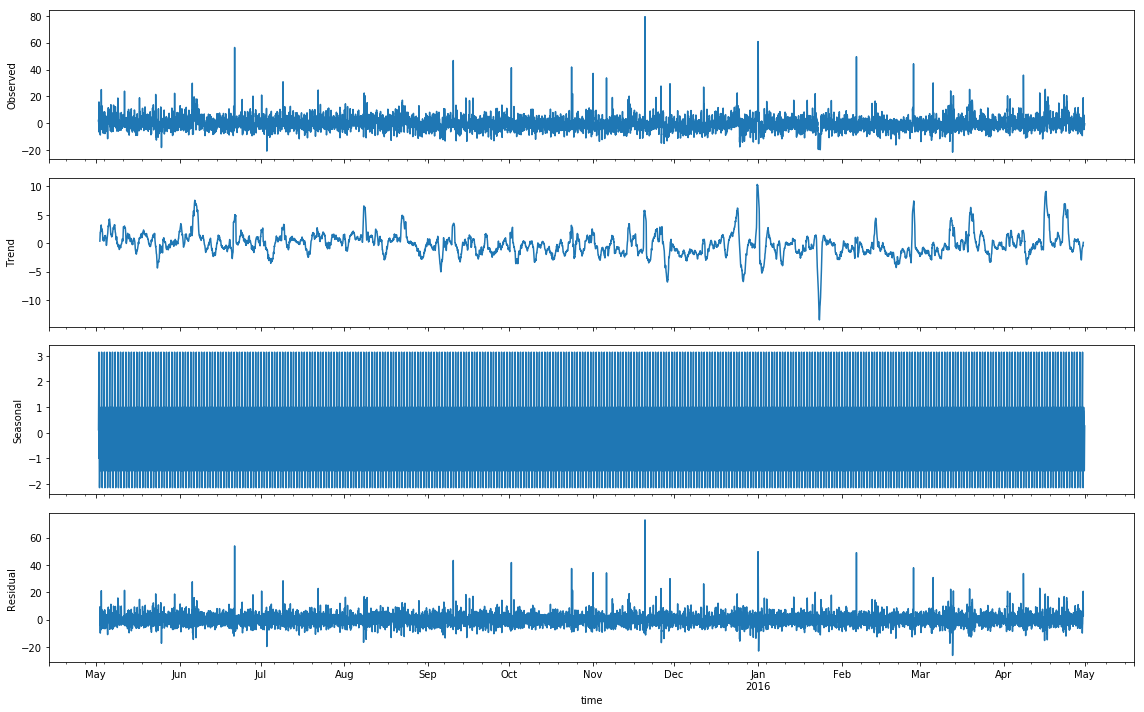

In [119]:
residual = train_series - predict
plt.figure(figsize(16,10))
sm.tsa.seasonal_decompose(residual[-n_samples:]).plot()
print("Критерий Дики-Фуллера: p=%f" % sm.tsa.stattools.adfuller(residual)[1])
plt.show()

Критерий Дики-Фуллера: p=0.000000


<Figure size 1152x720 with 0 Axes>

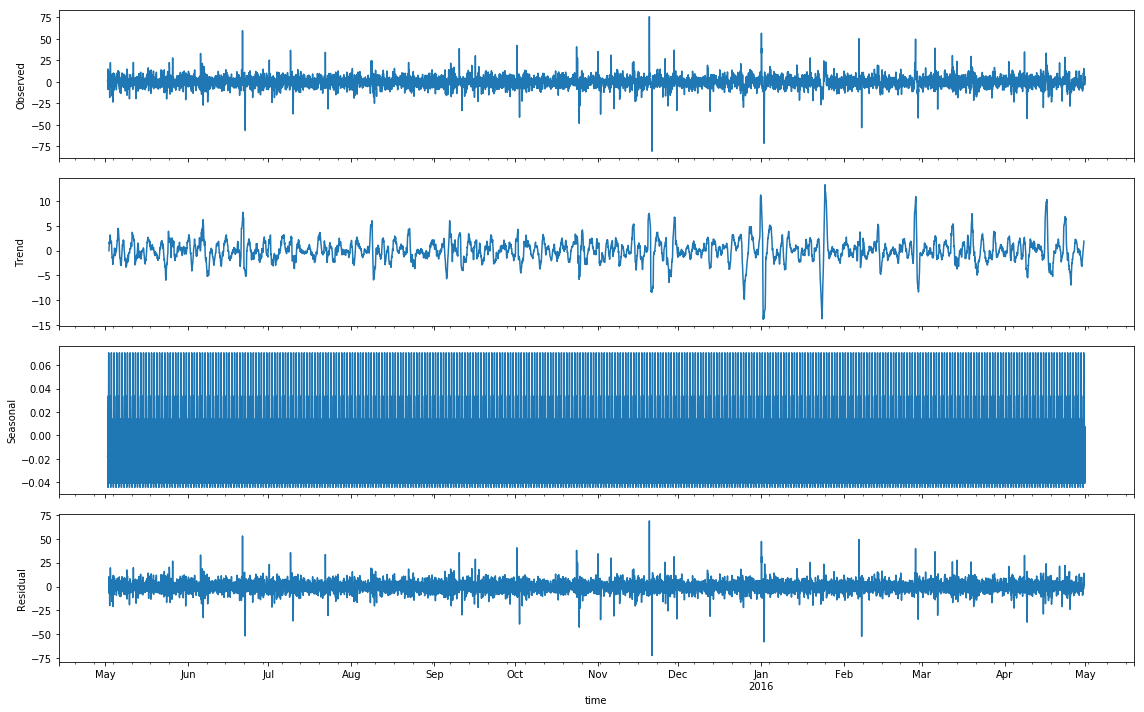

In [120]:
residual_diff = residual - residual.shift(24)
plt.figure(figsize(16,10))
sm.tsa.seasonal_decompose(residual_diff[-n_samples:].dropna()).plot()
print("Критерий Дики-Фуллера: p=%f" % sm.tsa.stattools.adfuller(residual_diff.dropna())[1])
plt.show()

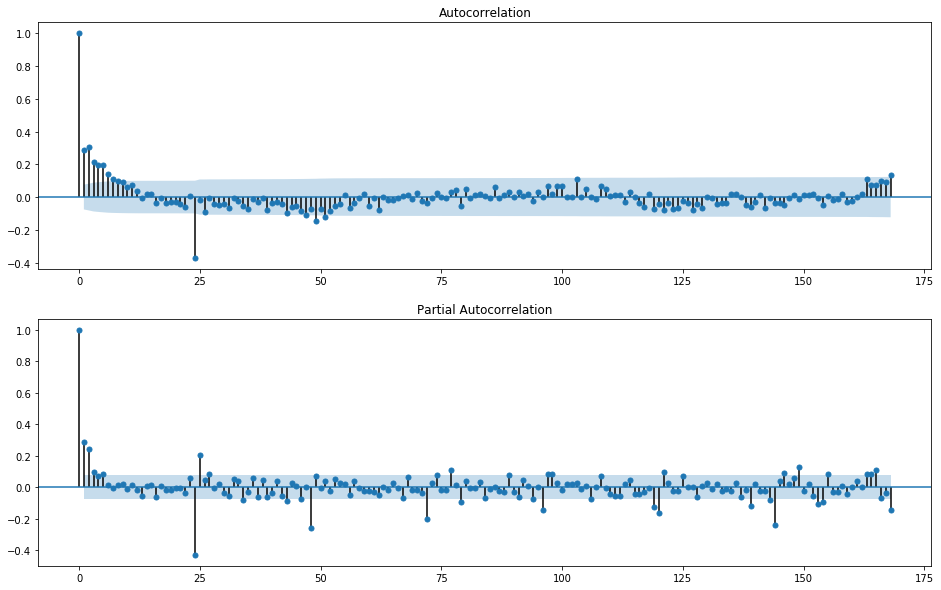

In [121]:
figure(figsize(16,10))
ax = subplot(211)
sm.graphics.tsa.plot_acf(residual_diff[-672:].dropna(), lags=168,ax=ax)
ax = subplot(212)
sm.graphics.tsa.plot_pacf(residual_diff[-672:].dropna(), lags=168,ax=ax)
plt.show()

Начальные приближения: Q=1, q=6, P=6, p=2

In [122]:
param.append((1,6,6,2))

#### Кластер 4

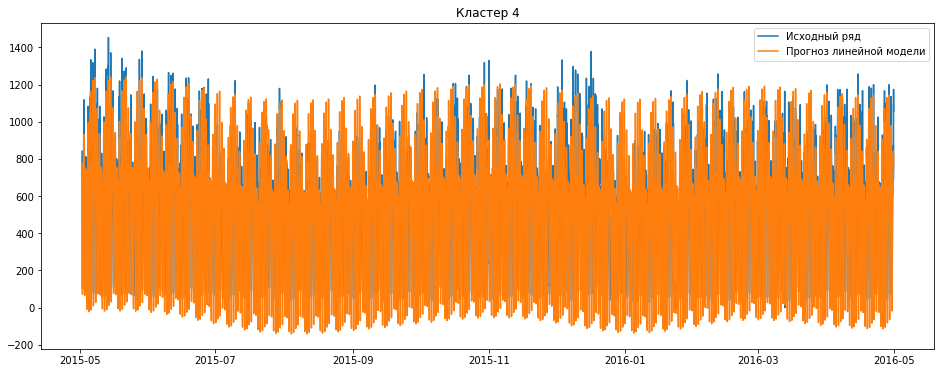

In [123]:
region = list_centers[3]
train_series = train_data.loc[:,region].resample('H').sum()
train_exog = generate_exog(train_data.loc[:,region].index, k_week=28, k_year=4, k_pol=3)
lin_model = linear_model.LinearRegression().fit(train_exog,train_series)
predict = lin_model.predict(train_exog)
plt.figure(figsize=(16,6))
plot(train_series.index[-n_samples:],train_series[-n_samples:],label='Исходный ряд')
plot(train_series.index[-n_samples:],predict[-n_samples:],label='Прогноз линейной модели')
plt.legend()
plt.title(f'Кластер 4')
plt.show()

Критерий Дики-Фуллера: p=0.000000


<Figure size 1152x720 with 0 Axes>

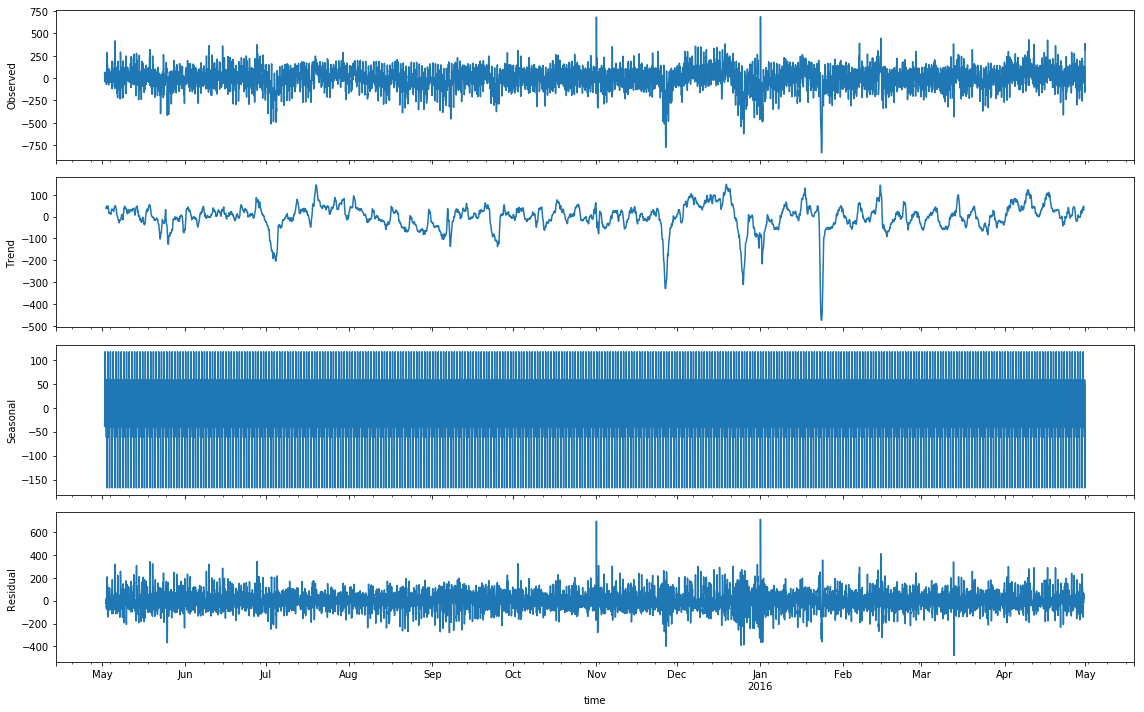

In [124]:
residual = train_series - predict
plt.figure(figsize(16,10))
sm.tsa.seasonal_decompose(residual[-n_samples:]).plot()
print("Критерий Дики-Фуллера: p=%f" % sm.tsa.stattools.adfuller(residual)[1])
plt.show()

Критерий Дики-Фуллера: p=0.000000


<Figure size 1152x720 with 0 Axes>

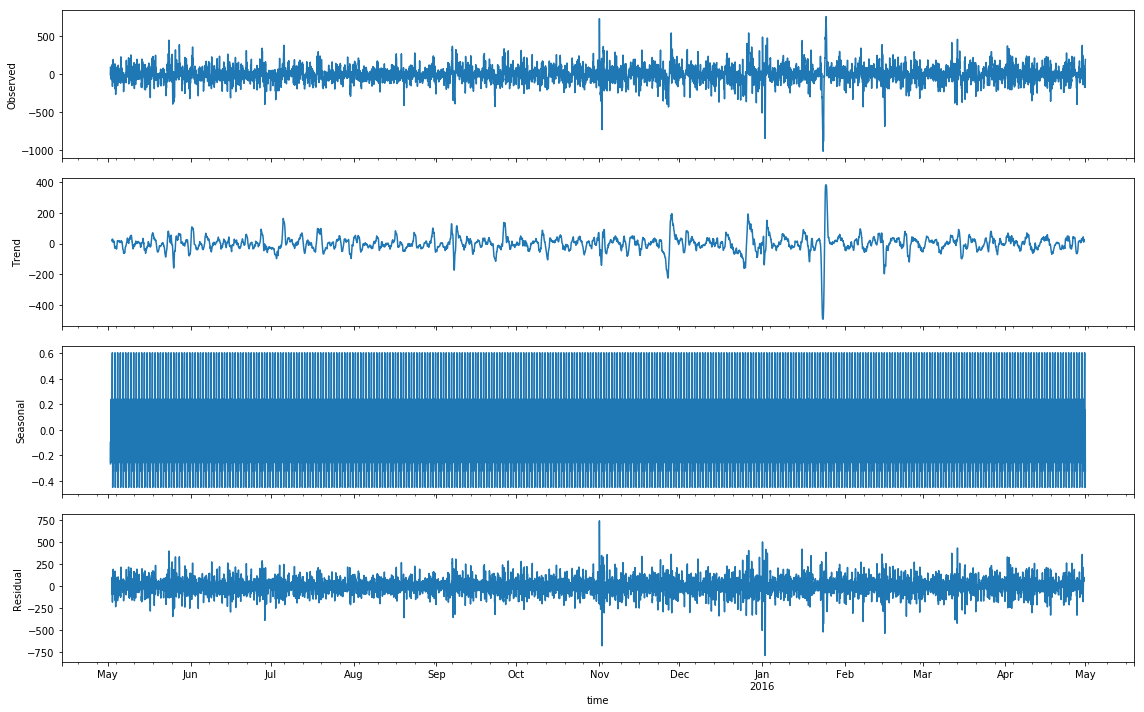

In [125]:
residual_diff = residual - residual.shift(24)
plt.figure(figsize(16,10))
sm.tsa.seasonal_decompose(residual_diff[-n_samples:].dropna()).plot()
print("Критерий Дики-Фуллера: p=%f" % sm.tsa.stattools.adfuller(residual_diff.dropna())[1])
plt.show()

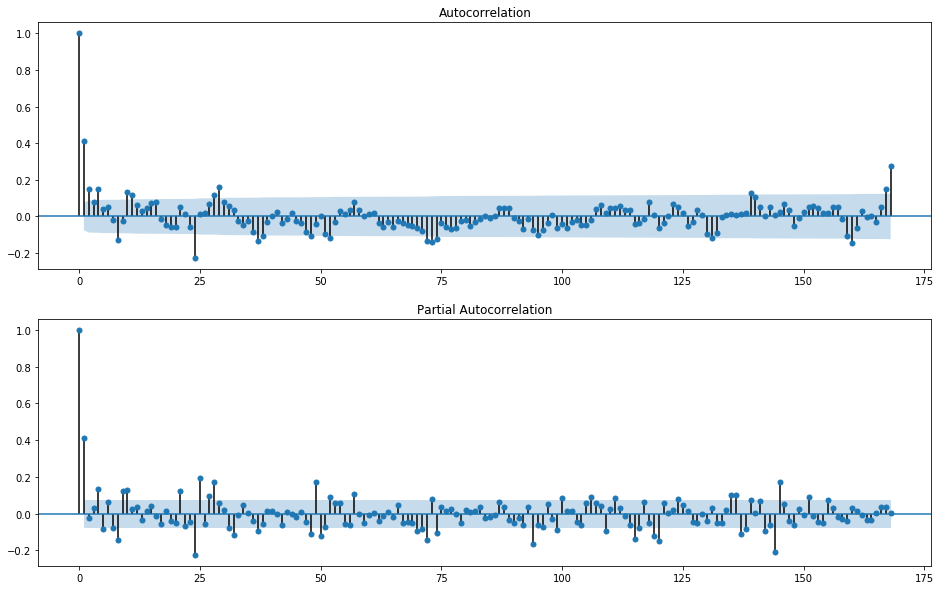

In [126]:
figure(figsize(16,10))
ax = subplot(211)
sm.graphics.tsa.plot_acf(residual_diff[-672:].dropna(), lags=168,ax=ax)
ax = subplot(212)
sm.graphics.tsa.plot_pacf(residual_diff[-672:].dropna(), lags=168,ax=ax)
plt.show()

Начальные приближения: Q=7, q=11, P=6, p=10

In [127]:
param.append((7,11,6,10))

#### Кластер 5

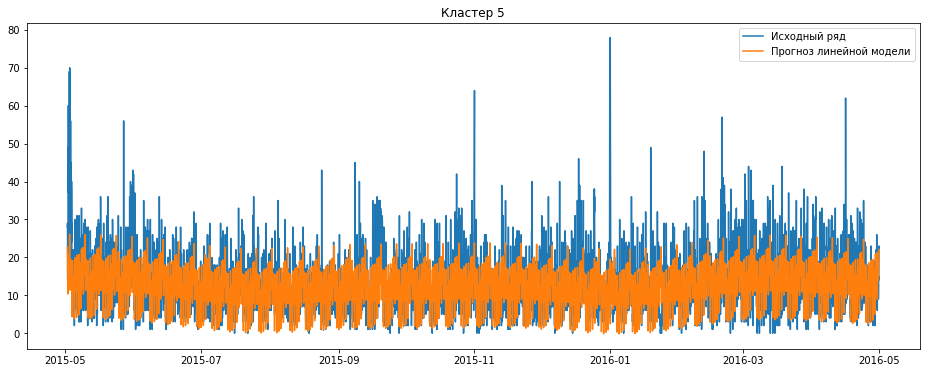

In [128]:
region = list_centers[4]
train_series = train_data.loc[:,region].resample('H').sum()
train_exog = generate_exog(train_data.loc[:,region].index, k_week=28, k_year=4, k_pol=3)
lin_model = linear_model.LinearRegression().fit(train_exog,train_series)
predict = lin_model.predict(train_exog)
plt.figure(figsize=(16,6))
plot(train_series.index[-n_samples:],train_series[-n_samples:],label='Исходный ряд')
plot(train_series.index[-n_samples:],predict[-n_samples:],label='Прогноз линейной модели')
plt.legend()
plt.title(f'Кластер 5')
plt.show()

Критерий Дики-Фуллера: p=0.000000


<Figure size 1152x720 with 0 Axes>

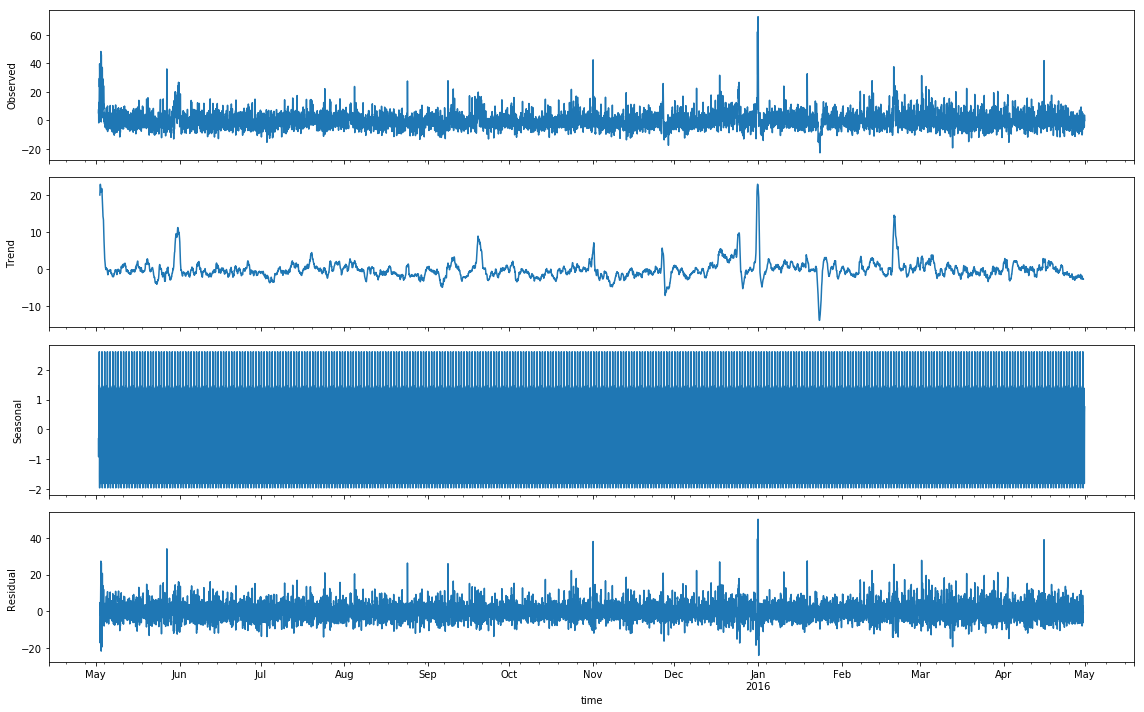

In [129]:
residual = train_series - predict
plt.figure(figsize(16,10))
sm.tsa.seasonal_decompose(residual[-n_samples:]).plot()
print("Критерий Дики-Фуллера: p=%f" % sm.tsa.stattools.adfuller(residual)[1])
plt.show()

Критерий Дики-Фуллера: p=0.000000


<Figure size 1152x720 with 0 Axes>

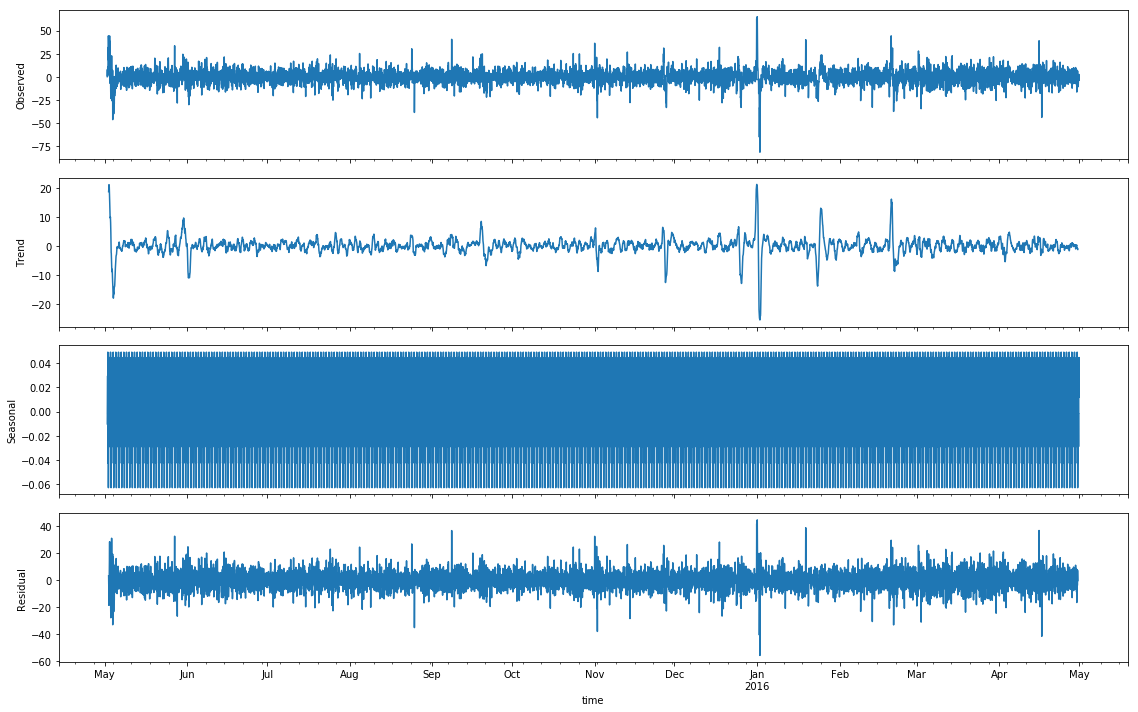

In [130]:
residual_diff = residual - residual.shift(24)
plt.figure(figsize(16,10))
sm.tsa.seasonal_decompose(residual_diff[-n_samples:].dropna()).plot()
print("Критерий Дики-Фуллера: p=%f" % sm.tsa.stattools.adfuller(residual_diff.dropna())[1])
plt.show()

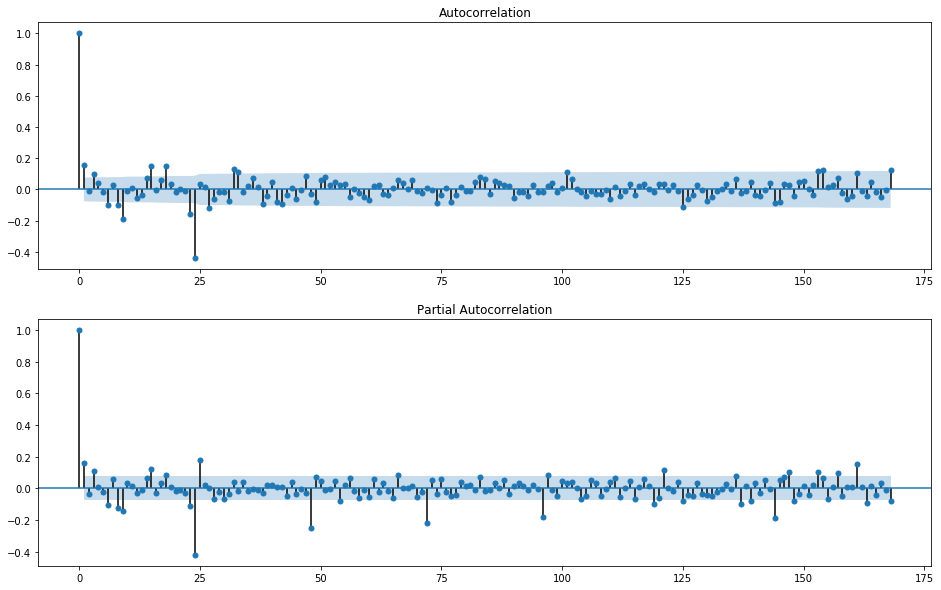

In [131]:
figure(figsize(16,10))
ax = subplot(211)
sm.graphics.tsa.plot_acf(residual_diff[-672:].dropna(), lags=168,ax=ax)
ax = subplot(212)
sm.graphics.tsa.plot_pacf(residual_diff[-672:].dropna(), lags=168,ax=ax)
plt.show()

Начальные приближения: Q=1, q=18, P=6, p=9

In [132]:
param.append((1,18,6,9))

В итоге получили список начальные приближений для 5 кластеров:

In [133]:
print(list(param))

[(7, 6, 5, 2), (7, 13, 6, 10), (1, 6, 6, 2), (7, 11, 6, 10), (1, 18, 6, 9)]


### Обучение ARIMA

Всё по стандартной схеме - долго и мучительно

In [134]:
class Model_sarima:
    
    def __init__(self,train_data,Q=1,q=1,P=1,p=1,d=0,D=1,k=24,exog_order=(6,4,3)):
        ps = range(0, p + 1)
        self.d = d
        qs = range(0, q + 1)
        Ps = range(0, P + 1)
        self.D = D
        Qs = range(0, Q + 1)
        self.k = k
        self.parameters_list = list(itertools.product(ps, qs, Ps, Qs))
        self.train_data = train_data
        self.exog_order = exog_order
        
        train_exog = generate_exog(train_data.index, k_week=self.exog_order[0], 
                                        k_year=self.exog_order[1], k_pol=self.exog_order[2])
        
        exog_model = linear_model.LinearRegression().fit(train_exog, train_data)
        predict_exog_model = pd.Series(exog_model.predict(train_exog),index=train_data.index)
        
        self.residual_exog_model = self.train_data - predict_exog_model
        
    def fit_sarima(self,len_fit):
        self.len_fit = len_fit
        results = []
        best_aic = float("inf")
        warnings.filterwarnings('ignore')
        for param in tqdm_notebook(self.parameters_list):
            try:
                model=sm.tsa.statespace.SARIMAX(self.residual_exog_model[-self.len_fit:],
                                                order=(param[0], self.d, param[1]),
                                                seasonal_order=(param[2], self.D, param[3], self.k),
                                                ).fit(disp=-1)
            except ValueError:
                continue
            aic = model.aic
            if aic < best_aic:
                self.best_model = model
                self.best_aic = aic
                self.best_param = param
            results.append([param, model.aic])
        warnings.filterwarnings('default')
        
    def Q_may(self, data, time_range):
        Q = []
        
        train_exog = generate_exog(data.index, k_week=self.exog_order[0], 
                                k_year=self.exog_order[1], k_pol=self.exog_order[2])
        
        exog_model = linear_model.LinearRegression().fit(train_exog[:len(data[:time_range[0]])], data[:time_range[0]])
        predict_exog_model = pd.Series(exog_model.predict(train_exog),index=data.index)
        
        
        model_fitted = sm.tsa.statespace.SARIMAX(data[-self.len_fit:],order=(self.best_param[0], 
                                                             self.d, self.best_param[1]), 
                                                 seasonal_order=(self.best_param[2], 
                                                                 self.D, self.best_param[3], 
                                                                 self.k),
                                                ).filter(self.best_model.params)
        for time in time_range:
            predict_model = model_fitted.predict(time+1, time+6, dynamic=True)
            predict_model = predict_model + predict_exog_model[time+1:time+6]
            Q.append(((data[time+1:time+6] - predict_model).abs()).sum())            
        return  sum(Q)
    
    def predict_kaggle(self, data, time_range):
        train_exog = generate_exog(data.index, k_week=self.exog_order[0], 
                                        k_year=self.exog_order[1], k_pol=self.exog_order[2])
        
        exog_model = linear_model.LinearRegression().fit(train_exog[:len(data[:time_range[0]])], data[:time_range[0]])
        predict_exog_model = pd.Series(exog_model.predict(train_exog),index=data.index)
                                                                                          
                                                                                          
                                                                                          
        predicted_data = []
        model_fitted = sm.tsa.statespace.SARIMAX(data[-self.len_fit:],order=(self.best_param[0], 
                                                             self.d, self.best_param[1]), 
                                                 seasonal_order=(self.best_param[2], 
                                                                 self.D, self.best_param[3], 
                                                                 self.k),
                                                ).filter(self.best_model.params)
        for time in time_range:
            predict_model = model_fitted.predict(time+1, time+6, dynamic=True)
            predict_model = predict_model + predict_exog_model[time+1:time+6]
            predicted_data.append(predict_model)            
        return predicted_data

In [93]:
models = []
for i, region in tqdm_notebook(enumerate(list_centers)):
    train_series = train_data.loc[:,region].resample('H').sum()
    Q = param[i][0]
    q = param[i][1]
    P = param[i][2]
    p = param[i][3]
    model = Model_sarima(train_series,Q=Q,q=q,P=P,p=p)
    model.fit_sarima(len_fit=739*2)
    models.append(model)

Для каждого конца истории от 2016.04.30 23:00 до 2016.05.31 17:00 построим прогноз на 6 часов вперёд и посчитаем в ноутбуке ошибку прогноза по следующему функционалу Q_may

In [94]:
Q_may = []
time_range = pd.date_range('2016.04.30 23:00','2016.05.31 17:00',freq='H')
for i, region in tqdm_notebook(enumerate(list_region)):
    series = all_data.loc[:,region].resample('H').sum()
    Q = models[assignments[i]].Q_may(series, time_range)
    Q_may.append(Q)
Q = sum(Q) / 102 / 739 / 6
print(f'Ошибка прогноза: {Q}')

Ошибка прогноза: 0.6568101101446148


In [100]:
predict_kaggle = []
time_range = pd.date_range('2016.05.31 23:00','2016.06.30 17:00',freq='H')
for i, region in tqdm_notebook(enumerate(list_region)):
    series = all_data.loc[:,region].resample('H').sum()
    predict = models[assignments[i]].predict_kaggle(series, time_range)
    for t, row in enumerate(predict):
        for j, y in enumerate(row.items()):
            idx = '_'.join([str(region),str(time_range[t].date()),str(time_range[t].hour),str(j+1)])
            y = str(int(y[1]))
            answer = ','.join([idx, y])
            predict_kaggle.append(answer)
print('\n'.join(predict_kaggle[:10]))

1075_2016-05-31_23_1,65
1075_2016-05-31_23_2,39
1075_2016-05-31_23_3,19
1075_2016-05-31_23_4,7
1075_2016-05-31_23_5,8
1075_2016-05-31_23_6,25
1075_2016-06-01_0_1,38
1075_2016-06-01_0_2,19
1075_2016-06-01_0_3,7
1075_2016-06-01_0_4,8


In [105]:
with open('results.csw','w') as f:
    f.write('id,y\n')
    f.write('\n'.join(predict_kaggle))

Ссылка https://www.kaggle.com/submissions/7963879/7963879.zip